<a href="https://colab.research.google.com/github/9uz/MobileNet/blob/main/MobilenetV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
# Set seeds to make the experiment more reproducible.
import random
def seed_everything(seed = 0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed = 0
seed_everything(seed)

In [3]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Define some parameters for the data loader:
BATCH_SIZE = 32
IMG_SIZE = 224

# Path of the dataset
input_path = '/content/drive/MyDrive/Dataset/padi_thermal/Dataset/test' # @param {type:"string"}

#datagen = ImageDataGenerator(
#rescale=1.0/255.0, # Normalize pixel values
#rotation_range=20, # Randomly rotate images
#width_shift_range=0.2, # Randomly shift image horizontally
#height_shift_range=0.2, # Randomly shift image vertically
#horizontal_flip=True # Randomly flip images horizontally
#)
#from keras.preprocessing.image import ImageDataGenerator
#train_datagen = ImageDataGenerator(zoom_range=0.15,width_shift_range=0.2,shear_range=0.15)
#test_datagen = ImageDataGenerator()


train_ds = tf.keras.utils.image_dataset_from_directory(
  input_path,
  validation_split=0.2,
  subset="training",
  seed=1,
  image_size = (IMG_SIZE, IMG_SIZE),
  batch_size = BATCH_SIZE,shuffle = True)

val_ds = tf.keras.utils.image_dataset_from_directory(
  input_path,
  validation_split=0.2,
  subset="validation",
  seed=1,
  image_size = (IMG_SIZE, IMG_SIZE),
  batch_size = BATCH_SIZE,shuffle = True)


class_names = train_ds.class_names
n_classes = len(class_names)
print(class_names)

AUTOTUNE = tf.data.AUTOTUNE
def prepare_dataset(ds):
    def input_preprocess(image, label):
        label = tf.one_hot(label, n_classes)
        return image, label
    ds = ds.map(input_preprocess, num_parallel_calls = AUTOTUNE)
    ds = ds.cache().prefetch(buffer_size = AUTOTUNE)
    return ds

train_ds = prepare_dataset(train_ds)
val_ds = prepare_dataset(val_ds)

Found 222 files belonging to 5 classes.
Using 178 files for training.
Found 222 files belonging to 5 classes.
Using 44 files for validation.
['BLB', 'Blast', 'healthy', 'hispa', 'leaf_spot']


In [14]:
def MobileNet_model(learning_rate, size,class_number, fine_tune):
    inputs = layers.Input(shape = (size, size, 3))
    x = layers.Rescaling(1.0/255)(inputs)
    baseModel = MobileNet(include_top=False, input_tensor = x,
                            weights='imagenet',input_shape=(size, size, 3))

   # Freeze the pretrained weights
    if fine_tune > 0:
        for layer in baseModel.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in baseModel.layers:
            layer.trainable = False

    model = keras.models.Sequential()
    model.add(baseModel)
    model.add(layers.AveragePooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation="relu"))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(50, activation="relu"))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(class_number, activation='softmax'))

    ##  compile model dengan optimizer adam
    model.compile(loss= "categorical_crossentropy", metrics=["accuracy"],
                  optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),)
    return model



In [15]:
## mobilenet
lr = 0.0001
model = MobileNet_model(lr,IMG_SIZE,n_classes,2)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 average_pooling2d (Average  (None, 3, 3, 1024)        0         
 Pooling2D)                                                      
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 512)               4719104   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                2

In [ ]:
# ModelCheckpoint callback - save best weights
tempatmodel=input_path+"mobilenetv2_best_weights_adam.keras" # @param {type:"string"}
tl_checkpoint_1 = ModelCheckpoint(filepath =tempatmodel ,
                                  save_best_only = True,
                                  verbose = 0)

# EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 10,
                           restore_best_weights = True,
                           mode = 'min')

rlrop = ReduceLROnPlateau(monitor = 'val_loss',
                          factor = 0.5,
                          patience = 3,
                          verbose = 1)
epochs = 100
history = model.fit(train_ds,
                    epochs = epochs,
                    validation_data = val_ds,
                    callbacks = [tl_checkpoint_1, early_stop, rlrop],
                    batch_size=32,
                    verbose = 2)

Epoch 1/100


In [ ]:
Test_score = model.evaluate(val_ds)
Test_score

7/7 [==============================] - 0s 63ms/step - loss: 0.1383 - accuracy: 0.9595


[0.1383008360862732, 0.9594594836235046]

# Confusion Matrix of our Model

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.figure(figsize=(10,10))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

7/7 [==============================] - 0s 44ms/step
Confusion Matrix
Confusion matrix, without normalization


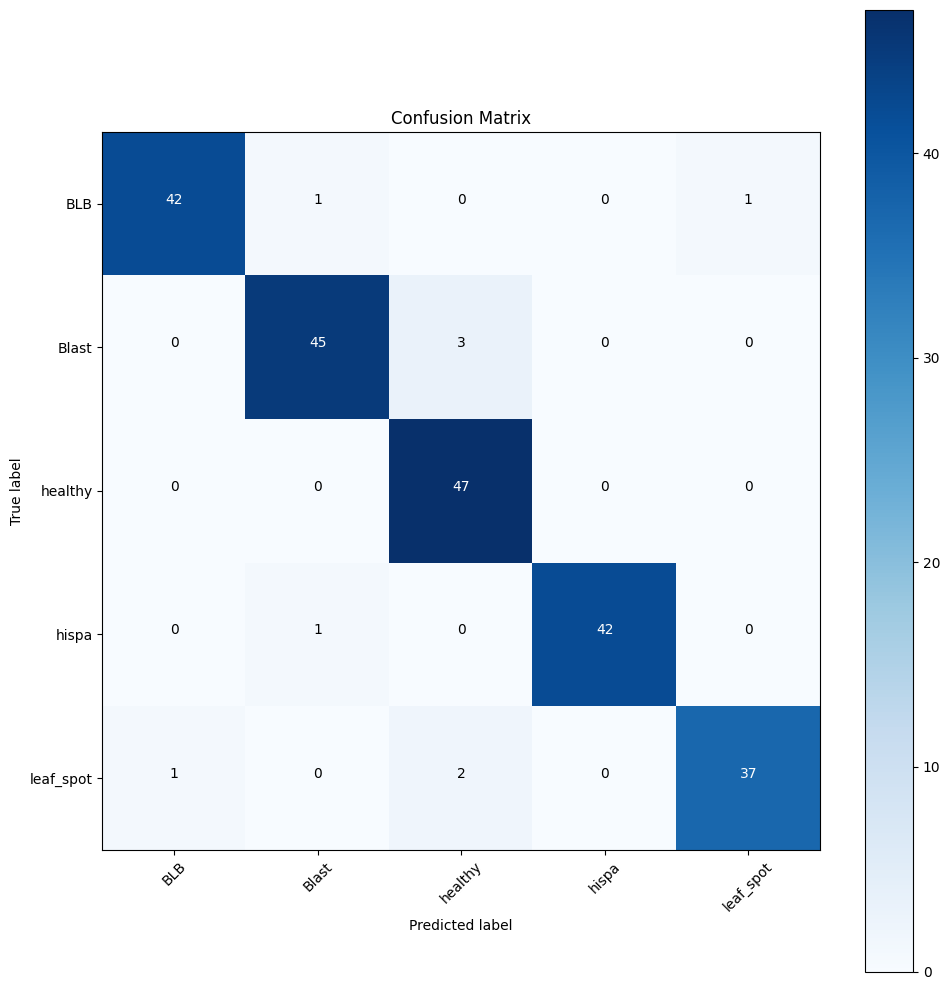

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
#Confution Matrix and Classification Report
hasil = model.predict(val_ds)
# hasil prediksii
pred_Model = np.argmax(hasil, axis=-1)
## kelas  pada data test
y_test = np.concatenate([y for x, y in val_ds], axis=0)
test_class=np.argmax(y_test,axis=1)

print('Confusion Matrix')
CM_Model=confusion_matrix(test_class, pred_Model)
plot_confusion_matrix(CM_Model, class_names, title='Confusion Matrix')

#Classification Report

In [ ]:
print('Classification Report')
predicted_classes = np.argmax(np.round(hasil),axis=1)
print(classification_report(test_class, predicted_classes, target_names=class_names))

Classification Report
              precision    recall  f1-score   support

         BLB       0.98      0.95      0.97        44
       Blast       0.96      0.94      0.95        48
     healthy       0.90      1.00      0.95        47
       hispa       1.00      0.98      0.99        43
   leaf_spot       0.97      0.93      0.95        40

    accuracy                           0.96       222
   macro avg       0.96      0.96      0.96       222
weighted avg       0.96      0.96      0.96       222



#Plotting Accuracy and Loss

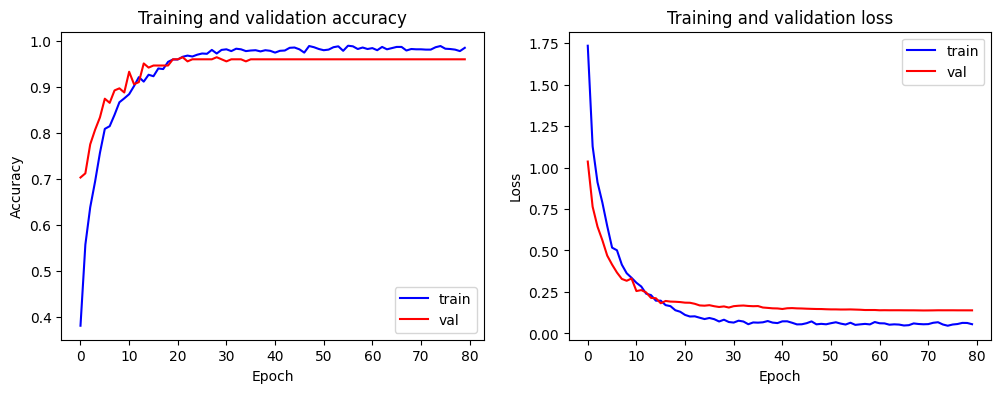

In [ ]:
Train_accuracy = history.history['accuracy']
Val_accuracy = history.history['val_accuracy']
Train_loss = history.history['loss']
Val_loss = history.history['val_loss']

epochs = range(len(Train_accuracy))
plt.figure(figsize=(12,4))

# Plotting the accuracy
plt.subplot(1,2,1)
plt.plot(epochs, Train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, Val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')

# Plotting the loss
plt.subplot(1,2,2)
plt.plot(epochs, Train_loss, 'b', label='Training loss')
plt.plot(epochs, Val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')

plt.show()